# Train

In [1]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import AUTOTUNE
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

## Set paramaters

In [2]:
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
DATA_PATH = 'processed/train'
NUM_CLASSES = len(os.listdir(DATA_PATH))
MODEL_NAME = 'model.hdf5'

## Read dataset

In [3]:
train_ds = image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds = image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 12244 files belonging to 6 classes.
Using 9796 files for training.
Found 12244 files belonging to 6 classes.
Using 2448 files for validation.


In [4]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create neural network architecture

In [5]:
model = Sequential([
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(NUM_CLASSES, activation='softmax')
])

## Compile and train neural network

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.compile(
  optimizer='adam',
  loss=categorical_crossentropy,
  metrics=['accuracy'])

history  = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks = [early_stop, check_point],  
  epochs=100
)

Epoch 1/100
307/307 [==============================] - 40s 116ms/step - loss: 0.7935 - accuracy: 0.6987 - val_loss: 0.5207 - val_accuracy: 0.7904
Epoch 2/100
307/307 [==============================] - 17s 56ms/step - loss: 0.2046 - accuracy: 0.9277 - val_loss: 0.3440 - val_accuracy: 0.8587
Epoch 3/100
307/307 [==============================] - 20s 65ms/step - loss: 0.0972 - accuracy: 0.9669 - val_loss: 0.1173 - val_accuracy: 0.9596
Epoch 4/100
307/307 [==============================] - 17s 57ms/step - loss: 0.0690 - accuracy: 0.9774 - val_loss: 0.0880 - val_accuracy: 0.9673
Epoch 5/100
307/307 [==============================] - 19s 61ms/step - loss: 0.0412 - accuracy: 0.9855 - val_loss: 0.0900 - val_accuracy: 0.9714
Epoch 6/100
307/307 [==============================] - 19s 61ms/step - loss: 0.0314 - accuracy: 0.9888 - val_loss: 0.0729 - val_accuracy: 0.9779
Epoch 7/100
307/307 [==============================] - 20s 64ms/step - loss: 0.0341 - accuracy: 0.9886 - val_loss: 0.1256 - val_a

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9

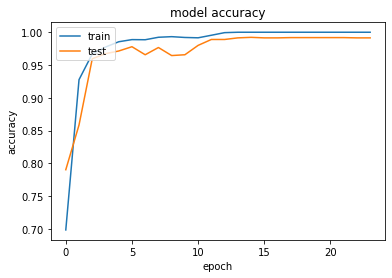

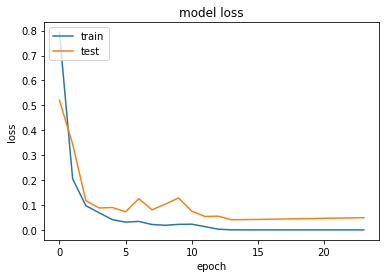

In [7]:
model.summary()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
def predict_all_videos(model, source_dir):
    for test_dir in os.listdir(source_dir):
        test_source_dir = os.path.join(source_dir, test_dir)
        res = np.zeros((1,6), dtype=np.float32)
        for image_name in os.listdir(test_source_dir):
            image_path = os.path.join(test_source_dir, image_name)
            face_pixels = cv2.imread(image_path)
            image = Image.fromarray(face_pixels)
            image.convert('RGB')
            image = image.resize((IMG_HEIGHT,IMG_WIDTH))
            face_array = np.asarray(image)
            face_array = face_array[np.newaxis, ...]
            res += model.predict(face_array)
        print(res)
            

In [9]:
predict_all_videos(model, 'processed/test')

[[2.6396597e+01 3.5377483e+00 6.5456279e-02 4.0627040e-20 2.7030949e-11
  1.9928165e-04]]
[[1.1547495e-06 4.2798481e+00 6.0781183e+00 9.8799443e-05 2.9641825e+01
  1.1112940e-04]]
[[4.1375916e-02 1.2590175e-06 6.7328185e-01 5.0033117e-07 6.2548475e+00
  1.8030493e+01]]
[[7.2615658e-04 2.8662507e-08 8.0236959e+00 1.9220703e-05 1.3571366e+01
  7.4041939e+00]]
[[1.6536442e+01 3.1368630e-10 5.8832392e-04 6.7380190e-09 2.3909068e+00
  1.2072063e+01]]
[[5.5080638e+00 2.2100313e+01 8.3827000e+00 1.8030999e-08 6.4708871e-08
  8.9218821e-03]]
[[5.8136082e-01 1.6005791e-07 1.6560313e+00 3.9662245e-07 1.4357271e+01
  1.5405335e+01]]
[[ 5.2303143   0.96452653  8.715882   10.1297245   3.7674851   2.1920667 ]]
[[8.3656684e-12 7.7337574e-18 5.3520656e+00 2.5932154e-09 9.4289368e-07
  2.2647936e+01]]
[[5.7653961e-19 3.5000000e+01 4.0638232e-10 2.1279626e-11 2.0326138e-06
  2.0238234e-26]]
[[4.5238282e-21 6.6906938e-15 7.8597906e-10 2.0759924e-06 3.1000000e+01
  6.2453437e-10]]
[[1.7949007e+01 1.528799

[[8.9348696e-02 2.8309004e+00 2.2015303e-05 2.0079720e+01 6.2876120e-06
  2.6824937e-06]]
[[2.1099122e-08 1.5782499e-07 2.5959492e+01 7.0921541e-12 1.0405077e+00
  4.6645887e-08]]
[[1.0581085e-12 3.6260958e-10 3.1000000e+01 3.9253480e-18 2.6728690e-08
  6.0115340e-10]]
[[1.3023821e+01 3.3716660e+00 3.6043906e+00 1.3223194e-12 5.4020544e-05
  6.7637629e-05]]
[[1.19386431e-10 1.96104361e-06 1.39875785e-11 2.29999981e+01
  1.38736132e-11 4.62617717e-15]]
[[4.5214114e-11 1.6294244e-06 5.0320503e-10 2.3999998e+01 1.3153597e-12
  5.0802812e-12]]
[[9.5380699e-07 2.7000000e+01 8.6434720e-11 3.6208222e-14 1.9983995e-16
  2.8173593e-23]]
[[1.3268955e-07 4.2879357e-08 2.3999937e+01 1.5749186e-17 6.0915743e-05
  2.5999664e-06]]
[[7.1911787e-17 1.0317114e-05 2.8739895e+01 1.9358045e-17 3.4511511e-03
  2.5664625e-01]]
[[3.8119452e-20 4.6107928e-21 2.7984114e+00 4.1717505e-24 6.4702449e-10
  2.8201591e+01]]
[[1.4760060e-10 1.7803393e-02 1.2092761e+01 1.7888081e+01 1.2253262e-03
  1.3068228e-04]]
[[1.

[[7.0761932e-16 2.5000000e+01 1.8056005e-08 2.0637456e-22 6.8013522e-16
  1.9751755e-13]]
[[3.5669624e-11 7.1286917e+00 2.0105081e+00 5.2754432e-03 2.8889494e+00
  1.2966575e+01]]
[[1.0840886e-18 2.6521129e-06 2.4573363e-02 6.9603419e-05 5.0011210e-11
  1.9975355e+01]]
[[2.2320699e-15 2.6000000e+01 1.9654068e-07 1.2229337e-13 3.1696814e-08
  5.1862810e-07]]
[[1.0724544e-14 1.4772463e-02 3.0555167e+00 2.0014033e-05 1.3094375e-01
  1.9798746e+01]]
[[5.9285014e-11 4.0432277e+00 1.0642549e+01 2.2758395e-07 1.1131864e-06
  9.3142204e+00]]
[[6.1787211e-09 2.0002697e+00 1.5155718e+01 3.0168978e-11 2.7035722e-07
  5.8440127e+00]]
[[7.5824999e-11 3.1080794e-02 1.2563373e+01 1.1892233e-06 3.6776767e-04
  7.4051785e+00]]
[[3.6341663e-16 1.2713858e-01 3.5920603e+00 4.9348665e-07 2.9136596e-02
  2.1251665e+01]]
[[3.7406287e-26 4.4638693e-19 4.3647939e-09 6.8223665e-22 1.1470941e-18
  2.4000000e+01]]
[[2.0569242e-15 1.8451080e-06 1.5002389e+00 2.8686611e-06 3.1314339e-05
  2.4499727e+01]]
[[4.748016